## File and Data Field Descriptions
* ```train.csv``` - Personal records for about two-thirds (~8700) of the pas sengers, to be used as training data.
  * ```PassengerId``` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
  * ```HomePlanet``` - The planet the passenger departed from, typically their planet of permanent residence.
  * ```CryoSleep``` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  * ```Cabin``` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  * ```Destination``` - The planet the passenger will be debarking to.
  * ```Age``` - The age of the passenger.
  * ```VIP``` - Whether the passenger has paid for special VIP service during the voyage.
  * ```RoomService```, ```FoodCourt```, ```ShoppingMall```, ```Spa```, ```VRDeck``` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  * ```Name``` - The first and last names of the passenger.
  * ```Transported``` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
  * ```test.csv``` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
  * ```sample_submission.csv``` - A submission file in the correct format.
  * ```PassengerId``` - Id for each passenger in the test set.
  * ```Transported``` - The target. For each passenger, predict either True or False.

In [6]:
!pip install kaggle

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-7.0.0-py2.py3-none-any.whl (9.4 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [2]:
!pwd

/root/spacship_competition/notebooks


In [3]:
import sys
for path in sys.path:
    print(path)

/root/spacship_competition/notebooks
/opt/conda/lib/python37.zip
/opt/conda/lib/python3.7
/opt/conda/lib/python3.7/lib-dynload

/opt/conda/lib/python3.7/site-packages
/opt/conda/lib/python3.7/site-packages/IPython/extensions
/root/.ipython


In [4]:
sys.path.insert(0, '/root/spacship_competition')

In [7]:
# All the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from src.data_download import download_data, unzip_data
from src.data_cleaning import DataFrameImputation, ColumnSplitter
from src.scaling_numeric_attr import standardize_numeric_columns

In [8]:
download_data("spaceship-titanic", "/root/.kaggle/kaggle.json")
unzip_data("spaceship-titanic", "/root/spacship_competition/data/raw")

In [9]:
# Read the CSV file and store it in a dataframe 
df_train=pd.read_csv('/root/spacship_competition/data/raw/train.csv')

In [10]:
# Visualize the trianing raw data
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
# Group the data by the VIP attribute with null values and count the number of null values for each group
null_counts = df_train.groupby(['HomePlanet']).apply(lambda x: x.isnull().mean())
# Print the null counts 
print(null_counts)

            PassengerId  HomePlanet  CryoSleep     Cabin  Destination  \
HomePlanet                                                              
Earth               0.0         0.0   0.024772  0.020643     0.021512   
Europa              0.0         0.0   0.027217  0.028625     0.017363   
Mars                0.0         0.0   0.024446  0.021035     0.023877   

                 Age       VIP  RoomService  FoodCourt  ShoppingMall  \
HomePlanet                                                             
Earth       0.019122  0.024989     0.022382   0.021078      0.024337   
Europa      0.021586  0.019709     0.016893   0.021586      0.024871   
Mars        0.024446  0.024446     0.020466   0.021603      0.020466   

                 Spa    VRDeck      Name  Transported  
HomePlanet                                             
Earth       0.021512  0.024120  0.023033          0.0  
Europa      0.021117  0.017363  0.021586          0.0  
Mars        0.020466  0.022172  0.023309         

In [12]:
# Group the data by the VIP attribute with null values and count the number of null values for each group
null_counts = df_train.groupby(['VIP']).apply(lambda x: x.isnull().mean())
# Print the null counts
print(null_counts)

       PassengerId  HomePlanet  CryoSleep     Cabin  Destination       Age  \
VIP                                                                          
False          0.0    0.023278   0.024967  0.022555     0.021228  0.020745   
True           0.0    0.025126   0.015075  0.030151     0.010050  0.005025   

       VIP  RoomService  FoodCourt  ShoppingMall      Spa    VRDeck      Name  \
VIP                                                                             
False  0.0     0.020866   0.020866      0.024002  0.02159  0.022072  0.023640   
True   0.0     0.020101   0.030151      0.025126  0.01005  0.020101  0.015075   

       Transported  
VIP                 
False          0.0  
True           0.0  


In [13]:
# Print the first five rows of the DataFrame
df_train.shape

(8693, 14)

In [14]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [15]:
splitter = ColumnSplitter(df=df_train, column='Cabin', sep='/')

In [16]:
splitter.split_column(ordered_required_columns=['deck', 'num', 'side'])

In [17]:
df_train.isnull().mean()

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
deck            0.022892
num             0.022892
side            0.022892
dtype: float64

In [18]:
transformer = DataFrameImputation(df_train)
transformer.impute_numeric_columns()
transformer.impute_string_columns()

In [19]:
transformer.extract_features(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'deck', 'num', 'side', 'Transported'])

In [20]:
transformer.df.set_index('PassengerId', inplace=True)

In [21]:
transformer.df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side,Transported
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,False
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,True
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,False
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,False
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,True


In [22]:
transformer.df.isnull().mean()

HomePlanet      0.0
CryoSleep       0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Name            0.0
deck            0.0
num             0.0
side            0.0
Transported     0.0
dtype: float64

In [23]:
# Print a summary of the statistical properties of each numeric column
transformer.df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.339054,659.739364,1594.434978,597.417440,1124.675871,1133.259049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,78.000000,118.000000,45.000000,89.000000,71.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [24]:
standardized_data_frame = standardize_numeric_columns(df=transformer.df)

In [25]:
standardized_data_frame.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03,8.693000e+03
mean,-1.353264e-16,2.480122e-16,-5.512162e-16,-6.683433e-16,-2.304865e-16,-8.077757e-16
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-2.010564e+00,-3.405899e-01,-2.873140e-01,-2.908170e-01,-2.766634e-01,-2.690226e-01
25%,-6.156918e-01,-3.405899e-01,-2.873140e-01,-2.908170e-01,-2.766634e-01,-2.690226e-01
50%,-1.274865e-01,-3.405899e-01,-2.873140e-01,-2.908170e-01,-2.766634e-01,-2.690226e-01
75%,5.699497e-01,-2.223546e-01,-2.133024e-01,-2.154885e-01,-1.975250e-01,-2.063679e-01
max,3.499182e+00,2.137681e+01,1.841192e+01,3.903403e+01,1.964845e+01,2.102742e+01


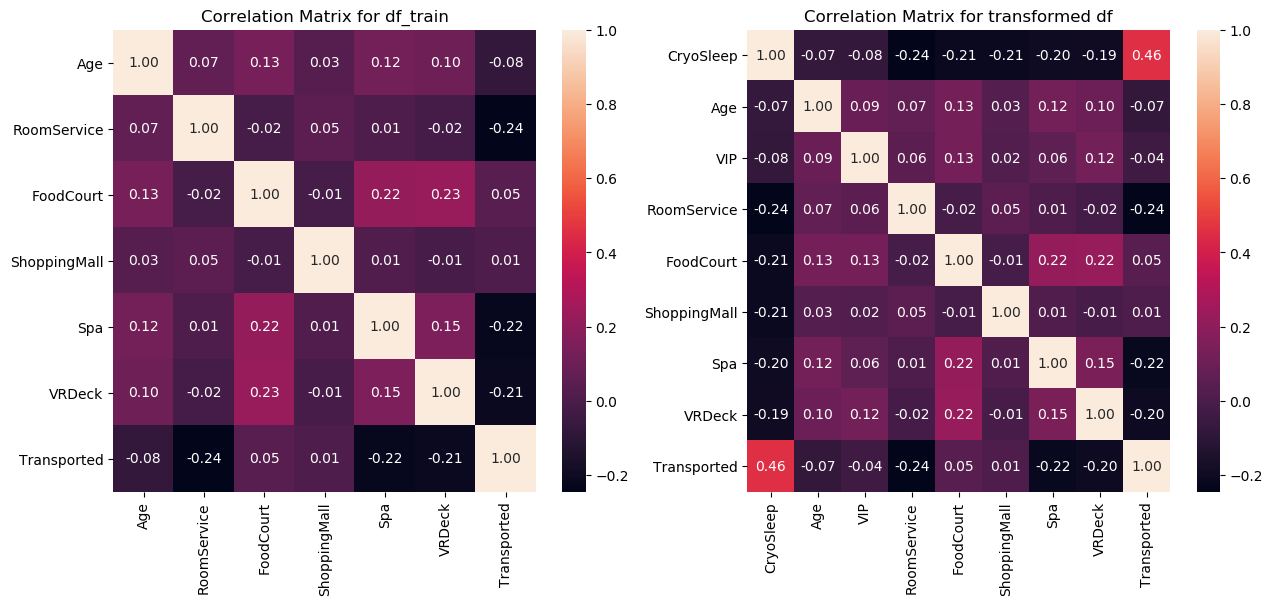

In [26]:
# Create the figure and subplots
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Compute the correlation matrix for the first dataframe
corr1 = df_train.corr()

# Create a heatmap with the correlation numbers for the first dataframe
sns.heatmap(corr1, xticklabels=corr1.columns, yticklabels=corr1.columns, annot=True, fmt='.2f', ax=ax1)
ax1.set_title('Correlation Matrix for df_train')

# Compute the correlation matrix for the second dataframe
corr2 = transformer.df.corr()

# Create a heatmap with the correlation numbers for the second dataframe
sns.heatmap(corr2, xticklabels=corr2.columns, yticklabels=corr2.columns, annot=True, fmt='.2f', ax=ax2)
ax2.set_title('Correlation Matrix for transformed df')

# Show the plot
plt.show()


#### Clean and preprocess the data: Next is cleaning and preprocessing the data to prepare it for analysis. This may include handling missing or null values, converting data types, and scaling numeric attributes.

* Handling missing or null values
* Converting data types
* Scaling numeric attributes

##### When the attributes have very different ranges of values, this can lead to some attributes dominating the model, since their values will be much larger than the values of other attributes.
##### So in this step, it is required to do the following:
* Select the numerical attributes
* Fillin the nulls
* Standardize the range and distribution of numeric attributes if applicable.

#### The null values are evenly distributed throughout the dataset, then dropping the rows may not have a significant impact on the overall distribution of the data.

### Visualizing the null numeric attributes with mean (percentage of nulls in the dataset) - Before and After

#### Before Imputing

In [27]:
df_train.groupby(['HomePlanet']).apply(lambda x: x.isnull().mean())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
HomePlanet,,,,,,,,,,,,,,,,,
Earth,0.0,0.0,0.024772,0.020643,0.021512,0.019122,0.024989,0.022382,0.021078,0.024337,0.021512,0.024120,0.023033,0.0,0.020643,0.020643,0.020643
Europa,0.0,0.0,0.027217,0.028625,0.017363,0.021586,0.019709,0.016893,0.021586,0.024871,0.021117,0.017363,0.021586,0.0,0.028625,0.028625,0.028625
Mars,0.0,0.0,0.024446,0.021035,0.023877,0.024446,0.024446,0.020466,0.021603,0.020466,0.020466,0.022172,0.023309,0.0,0.021035,0.021035,0.021035


#### After Imputing

In [28]:
transformer.df.groupby(['HomePlanet']).apply(lambda x: x.isnull().mean())

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side,Transported
HomePlanet,,,,,,,,,,,,,,,
Earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Europa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* ```test.csv``` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

In [29]:
df_test=pd.read_csv('/root/spacship_competition/data/raw/test.csv')

In [30]:
df_test.drop(columns='Name', inplace=True)

In [31]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


The performance of a machine learning model is required and the test set does not include the target variable that you want to predict.

One approach could be taken is to split the training set further into a new training set and a validation set. Then use the new training set to fit the model and the validation set to evaluate its performance. This way, it is possible to have a set of known true labels (the target variable in the validation set) that can be used to compare with the predicted labels produced by your model.

Another option would be to use a different evaluation metric that does not require true labels for the test set. For example, using a metric like mean squared error (MSE) or root mean squared error (RMSE) to evaluate the performance of the model. These metrics measure the difference between the predicted values and the true values, so they do not require the true labels to be known.

It's also worth noting that in real-world situations, it is not uncommon for the test set to not include the target variable. In these cases, it is essential to use an evaluation metric that does not require the true labels to be known.

The RMSE is a more commonly used metric than the MSE, especially in the field of statistics. It is often used in conjunction with other evaluation metrics, such as the mean absolute error (MAE) or the R-squared value, to provide a more comprehensive evaluation of a model's performance.

In [32]:
X_train_transformer = DataFrameImputation(df_train)
X_train_transformer.df['num'] = X_train_transformer.df['num'].astype(int, errors='ignore')
X_train_transformer.impute_numeric_columns()
X_train_transformer.impute_string_columns()
X_train_transformer.extract_features(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'deck', 'num', 'side', 'Transported'])
X_train_transformer.df.set_index('PassengerId', inplace=True)
X_train_standardized = standardize_numeric_columns(df=X_train_transformer.df)
X_train_df = X_train_standardized[X_train_standardized.columns.difference(['Transported'])]

X_train = X_train_df.values
y_train = X_train_standardized['Transported'].values

In [33]:
test_splitter = ColumnSplitter(df=df_test, column='Cabin', sep='/')
test_splitter.split_column(ordered_required_columns=['deck', 'num', 'side'])

X_test_transformer = DataFrameImputation(df_test)
X_test_transformer.df['num'] = X_test_transformer.df['num'].astype(int, errors='ignore')
X_test_transformer.impute_numeric_columns()
X_test_transformer.impute_string_columns()
X_test_transformer.extract_features(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'deck', 'num', 'side'])
X_test_transformer.df.set_index('PassengerId', inplace=True)

X_test_standardized = standardize_numeric_columns(df=X_test_transformer.df)

In [34]:
# Find the object like dtypes
X_train_df.dtypes == 'object'

Age             False
CryoSleep       False
Destination      True
FoodCourt       False
HomePlanet       True
RoomService     False
ShoppingMall    False
Spa             False
VIP             False
VRDeck          False
deck             True
num              True
side             True
dtype: bool

In [35]:
# Assume the data is stored in a Pandas dataframe called df
X_train_categorical = X_train_standardized[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']]
X_test_categorical = X_test_standardized[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']]
# Create an instance of the OneHotEncoder class
one_hot_encoder = OneHotEncoder()

In [36]:
# Use the fit_transform method to apply one-hot encoding to the categorical columns
X_train_one_hot = one_hot_encoder.fit_transform(X_train_categorical)
X_test_one_hot = one_hot_encoder.fit_transform(X_test_categorical)

In [37]:
# The resulting array has two columns: one for each possible category in the Cabin column
print(f"One hot-encoded categorical features' shape: Trainig = {X_train_one_hot.shape}, Testing = {X_test_one_hot.shape}")

One hot-encoded categorical features' shape: Trainig = (8693, 20), Testing = (4277, 20)


In [38]:
# Convert the one-hot encoded data to a Pandas dataframe
X_train_one_hot_df = pd.DataFrame(X_train_one_hot.toarray(), columns=one_hot_encoder.get_feature_names())
X_test_one_hot_df = pd.DataFrame(X_test_one_hot.toarray(), columns=one_hot_encoder.get_feature_names())

In [39]:
# Concatenate the one-hot encoded data with the original dataframe
train_df_encoded = pd.concat([X_train_df.reset_index(drop=True), X_train_one_hot_df.reset_index(drop=True)], axis=1)
test_df_encoded = pd.concat([X_test_transformer.df.reset_index(drop=True), X_test_one_hot_df.reset_index(drop=True)], axis=1)

In [40]:
train_df_encoded = train_df_encoded.drop(columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side'])
test_df_encoded = test_df_encoded.drop(columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side'])

In [41]:
# Extract the desired features from the testing set
X_train = train_df_encoded.values
# Extract the desired features from the testing set
X_test = test_df_encoded.values

In [42]:
X_train.shape, y_train.shape, X_test.shape

((8693, 27), (8693,), (4277, 27))

In [43]:
train_df_encoded.isnull().sum()

Age                 0
FoodCourt           0
RoomService         0
ShoppingMall        0
Spa                 0
VRDeck              0
num                 0
x0_Earth            0
x0_Europa           0
x0_Mars             0
x1_False            0
x1_True             0
x2_55 Cancri e      0
x2_PSO J318.5-22    0
x2_TRAPPIST-1e      0
x3_False            0
x3_True             0
x4_A                0
x4_B                0
x4_C                0
x4_D                0
x4_E                0
x4_F                0
x4_G                0
x4_T                0
x5_P                0
x5_S                0
dtype: int64

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

# Create a logistic regression model
model = LogisticRegression(solver='liblinear')

kfold = StratifiedKFold(n_splits=11, shuffle=True, random_state=1)
scores = cross_val_score(model, X_train, y_train, cv=kfold)

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = np.mean(scores)
std_dev = np.std(scores)

# Print the mean and standard deviation of the cross-validation scores
print(f'LogisticRegression Mean score: {mean_score:.3f}')
print(f'LogisticRegression Standard deviation: {std_dev:.3f}')

LogisticRegression Mean score: 0.791
LogisticRegression Standard deviation: 0.010


In [45]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree model
decision_tree_model = DecisionTreeClassifier()

# Use stratified k-fold cross-validation with 10 folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(decision_tree_model, X_train, y_train, cv=kfold)

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = np.mean(scores)
std_dev = np.std(scores)

# Print the mean and standard deviation of the cross-validation scores
print(f'DecisionTreeClassifier Mean score: {mean_score:.3f}')
print(f'DecisionTreeClassifier Standard deviation: {std_dev:.3f}')

DecisionTreeClassifier Mean score: 0.742
DecisionTreeClassifier Standard deviation: 0.019


In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict

# Create an SVM model with a linear kernel
support_vector_machine_model = SVC(kernel='rbf')

# Use stratified k-fold cross-validation with 10 folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(support_vector_machine_model, X_train, y_train, cv=kfold)

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = np.mean(scores)
std_dev = np.std(scores)

# Print the mean and standard deviation of the cross-validation scores
print(f'SVC Mean score: {mean_score:.3f}')
print(f'SVC Standard deviation: {std_dev:.3f}')

KeyboardInterrupt: 

The code below trains two AdaBoost models using different decision tree base models: 
* one with a depth of 2 and one with a depth of 4. 
* It then calculates the mean and standard deviation of the cross-validation scores for each model, which can give you an idea of which base model is performing better.

In [47]:
from sklearn.ensemble import AdaBoostClassifier

# # Create a decision tree model
# base_model = DecisionTreeClassifier()
# # Create an AdaBoost model using the decision tree as the base model
# ada_boost_model = AdaBoostClassifier(base_estimator=base_model)

# Create a decision tree model with a max depth of 2
dt_model_1 = DecisionTreeClassifier(max_depth=2)

# Create a decision tree model with a max depth of 4
dt_model_2 = DecisionTreeClassifier(max_depth=4)

# Create an AdaBoost model using the first decision tree as the base model
ada_model_1 = AdaBoostClassifier(base_estimator=dt_model_1)

# Create an AdaBoost model using the second decision tree as the base model
ada_model_2 = AdaBoostClassifier(base_estimator=dt_model_2)


# Use stratified k-fold cross-validation with 10 folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

scores_1 = cross_val_score(ada_model_1, X_train, y_train, cv=kfold)
scores_2 = cross_val_score(ada_model_2, X_train, y_train, cv=kfold)

# Calculate the mean and standard deviation of the cross-validation scores
mean_score_1 = np.mean(scores_1)
std_dev_1 = np.std(scores_1)

mean_score_2 = np.mean(scores_2)
std_dev_2 = np.std(scores_2)

# Print the mean and standard deviation of the cross-validation scores
print(f'AdaBoostClassifier Mean score: {mean_score_1:.3f} using max_depth = 2')
print(f'AdaBoostClassifier Standard deviation: {std_dev_1:.3f} using max_depth = 2')

print(f'AdaBoostClassifier Mean score: {mean_score_2:.3f} using max_depth = 4')
print(f'AdaBoostClassifier Standard deviation: {std_dev_2:.3f} using max_depth = 4')

AdaBoostClassifier Mean score: 0.798 using max_depth = 2
AdaBoostClassifier Standard deviation: 0.012 using max_depth = 2
AdaBoostClassifier Mean score: 0.778 using max_depth = 4
AdaBoostClassifier Standard deviation: 0.010 using max_depth = 4


In [48]:
!pip install xgboost

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)


In [ ]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Create an XGBoost model
xgb_model_1 = XGBClassifier()

# Define the parameter distribution for the learning rate and number of estimators
param_dist = {'learning_rate': uniform(0.1, 0.8),
              'n_estimators': [10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 90, 100, 110, 120, 125, 130, 135.],
              'max_depth': [2, 3, 4],
              'gamma': [0, 0.25, 0.5, 1]}

# Create a stratified k-fold cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Create the random search object
random_search = RandomizedSearchCV(xgb_model_1, param_dist, cv=kfold, scoring='accuracy', n_iter=10)

# Fit the random search object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_:.3f}')

In [61]:
# XGBoost model with learning rate 0.1 and 50 estimators
model = XGBClassifier(learning_rate=0.41144212647467904, n_estimators=40, gamma=1, max_depth=4)

# Use stratified k-fold cross-validation with 10 folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Calculate the cross-validation scores for each model
scores = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the mean and standard deviation of the cross-validation scores for each model
print(f'Mean score = {np.mean(scores):.3f}, Standard deviation = {np.std(scores):.3f}')

Mean score = 0.811, Standard deviation = 0.009


In [62]:
from sklearn.metrics import accuracy_score

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [66]:
y_pred = y_pred.astype(bool)

In [67]:
X_test_standardized['Transported'] = y_pred

In [68]:
X_test_standardized['Transported']

PassengerId
0013_01    False
0018_01    False
0019_01     True
0021_01    False
0023_01     True
           ...  
9266_02    False
9269_01    False
9271_01     True
9273_01    False
9277_01    False
Name: Transported, Length: 4277, dtype: bool

In [69]:
X_test_standardized['Transported'].to_csv('submission.csv', index=True)

In [70]:
!kaggle competitions submit -c spaceship-titanic  -f submission.csv -m "SageMaker - Submission via API"

100%|██████████████████████████████████████| 57.2k/57.2k [00:01<00:00, 37.0kB/s]
Successfully submitted to Spaceship Titanic

In [72]:
!kaggle competitions  leaderboard spaceship-titanic --show

 teamId  teamName                                        submissionDate       score    
-------  ----------------------------------------------  -------------------  -------  
8398674  CADang                                          2022-11-28 03:19:31  0.87795  
8593894  Involutional Neural Network                     2022-12-30 01:02:10  0.85527  
8402036  Karl Cini                                       2022-11-15 09:56:46  0.82253  
8657182  random sampling                                 2022-12-03 08:29:27  0.82160  
8881970  Viktor Taran                                    2022-12-27 05:34:36  0.81833  
9661997  Natasha Ismaliyana                              2022-12-27 07:16:49  0.81786  
8962869  Burak Kaya                                      2022-11-22 22:20:54  0.81739  
9627078  Haziq Kamarozaman                               2022-12-29 03:41:53  0.81739  
9663171  Micheal Ben                                     2022-12-25 07:28:47  0.81739  
9561059  HEXACODERS             